['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
398 398


Mean:  23.514572864321607
Median:  23.0
Mode:  ModeResult(mode=array([13.]), count=array([20]))
Bin 0 : 9.0 15.5 74
Bin 1 : 16.0 19.9 77
Bin 2 : 20.0 24.5 78
Bin 3 : 25.0 30.9 88
Bin 4 : 31.0 46.6 81


--LOW VARIANCE FILTER ON-- 

Selected: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
Features (total, selected): 7 7


--ML Model Output-- 



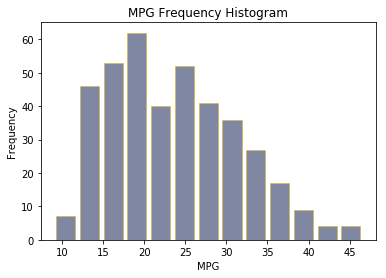

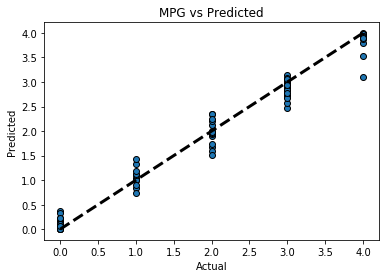

Random Forest RMSE:: 0.53 (+/- 0.17)
Random Forest Expl Var: 0.74 (+/- 0.39)
CV Runtime: 1.5589807033538818


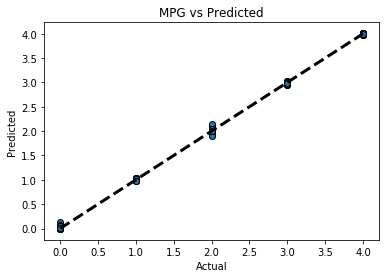


Gradient Boost RMSE:: 0.55 (+/- 0.18)
Gradient Boost Expl Var: 0.69 (+/- 0.44)
CV Runtime: 0.8921370506286621


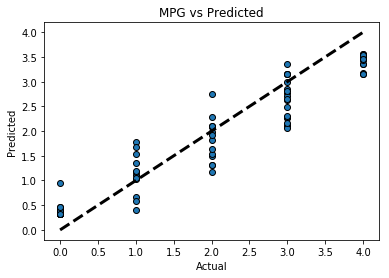


Ada Boost RMSE:: 0.59 (+/- 0.18)
Ada Boost Expl Var: 0.68 (+/- 0.45)
CV Runtime: 2.0121893882751465


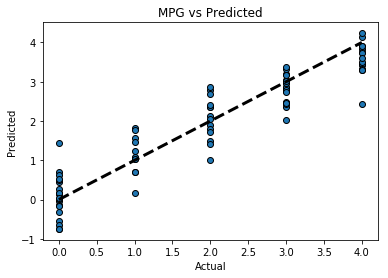


Neural Network Regressor RMSE:: 0.60 (+/- 0.12)
Neural Network Regressor Expl Var: 0.70 (+/- 0.32)
CV Runtime: 0.8837108612060547


In [7]:
#SciKit DSC540 Final Project

import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV                                                                                      
norm_target=0                                       #Normalize target switch
norm_features=0                                     #Normalize target switch
binning=1                                           #Control Switch for Bin Target
bin_cnt=5                                           #If bin target, this sets number of classes
feat_select=0                                       #Control Switch for Feature Selection
fs_type=2                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=1                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features

#Set global model parameters
rand_st=1                                           #Set Random State variable for randomizing splits on runs


#############################################################################
#
# Load Data
#
#####################

file1= csv.reader(open('auto-mpg.csv'), delimiter=',', quotechar='"')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,8):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)


#mean value
mean= np.mean(target_np)
#median value
median = np.median(target_np)
#mode value
mode = stats.mode(target_np)

print("Mean: ", mean)
print("Median: ", median)
print("Mode: ", mode)



plt.hist(target_np, bins='fd', histtype = 'bar', rwidth=0.8, facecolor='xkcd:navy blue', edgecolor='xkcd:gold', linewidth=1, alpha=0.5 )
plt.gca().set(title='MPG Frequency Histogram', ylabel='Frequency', xlabel='MPG');


#############################################################################
#
# Preprocess data
#
##########################################

if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)
    #plt.hist(target_np, bins='auto', density=True, alpha=0.75)
    #plt.gca().set(title='MPG Frequency Histogram', ylabel='Frequency', xlabel='MPG');

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

if binning==1:
    #Discretize Target variable with KBinsDiscretizer
    enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
    target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

    #Get Bin min/max
    temp=[[] for x in range(bin_cnt+1)]
    for i in range(len(target_np)):
        for j in range(bin_cnt):
            if target_np_bin[i]==j:
                temp[j].append(target_np[i])

    for j in range(bin_cnt):
        print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
    print('\n')

    #Convert Target array back to correct shape
    target_np=np.ravel(target_np_bin)


#############################################################################
#
# Feature Selection
#
##########################################

#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.2)                                          #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected:', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, min_samples_split=3, max_depth=3, random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           
            print ('Wrapper Select: ')
        if binning==0:
            rgr =GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, max_depth=3, min_samples_split=3, random_state=rand_st)
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)

#############################################################################
#
# Train SciKit Models
#
##########################################

print('--ML Model Output--', '\n')

#Test/Train split 20/80 ratio
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.20)

####Classifiers####
if cross_val==0:    
    #SciKit Random Forest
    clf = RandomForestClassifier(n_estimators=100, max_depth= None, random_state=rand_st, min_samples_split=3, criterion='entropy')   
    clf.fit(data_train, target_train)

    scores_ACC = clf.score(data_test, target_test)                                                                                                                          
    print('Random Forest Acc:', scores_ACC)
    scores_AUC = metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1])                                                                                      
    print('Random Forest AUC:', scores_AUC)                                                                     #AUC only works with binary classes, not multiclass            
 
####Cross-Val Regressors####
if cross_val==1:
    #Setup Crossval regressor scorers
    scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
    #SciKit Random Forest Regressor - Cross Val
    start_ts=time.time()
    rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth= None, random_state=rand_st, min_samples_split=3, criterion='mse')   
    scores = cross_validate(rgr, data_np, target_np, scoring=scorers, cv=10) 
    rgr.fit(data_np, target_np)
    y_predicted = rgr.predict(data_test)
    fig, ax = plt.subplots()
    ax.scatter(target_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=3)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title("MPG vs Predicted")
    plt.show()


    scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
    scores_Expl_Var = scores['test_expl_var']
    print("Random Forest RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
    print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
    print("CV Runtime:", time.time()-start_ts)
                    
    #SciKit Gradient Boosting - Cross Val
    start_ts=time.time()
    rgr=GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=100, max_depth=5, min_samples_split=3, random_state=rand_st)
    scores=cross_validate(rgr, data_np, target_np, scoring=scorers, cv=10)      
    rgr.fit(data_np, target_np)
    y_predicted = rgr.predict(data_test)
    fig, ax = plt.subplots()
    ax.scatter(target_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=3)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title("MPG vs Predicted")
    plt.show()

    scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
    scores_Expl_Var = scores['test_expl_var']
    
    print("\nGradient Boost RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
    print("Gradient Boost Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
    print("CV Runtime:", time.time()-start_ts)


    #SciKit Ada Boosting - Cross Val
    start_ts=time.time()
    rgr=AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=0.5, loss='linear', random_state=rand_st)
    scores=cross_validate(rgr, data_np, target_np, scoring=scorers, cv=10)
    rgr.fit(data_np, target_np)
    y_predicted = rgr.predict(data_test)
    fig, ax = plt.subplots()
    ax.scatter(target_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=3)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title("MPG vs Predicted")
    plt.show()


    scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
    scores_Expl_Var = scores['test_expl_var']
    print("\nAda Boost RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
    print("Ada Boost Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
    print("CV Runtime:", time.time()-start_ts)


    #SciKit Neural Network - Cross Val
    start_ts=time.time()
    rgr=MLPRegressor(activation='identity', solver = 'lbfgs', alpha =0.0001, max_iter=100, hidden_layer_sizes=(10, ), random_state=rand_st)
    scores=cross_validate(rgr, data_np, target_np, scoring=scorers, cv=10)
    rgr.fit(data_np, target_np)
    y_predicted = rgr.predict(data_test)
    fig, ax = plt.subplots()
    ax.scatter(target_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=3)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title("MPG vs Predicted")
    plt.show()


    scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
    scores_Expl_Var = scores['test_expl_var']
    print("\nNeural Network Regressor RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
    print("Neural Network Regressor Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
    print("CV Runtime:", time.time()-start_ts)

